In [1]:
from CO2xSWV import fetch_data_from_NEON_API, make_df
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import multiprocessing
from dataclasses import dataclass
import xarray as xr
import scipy.stats as stats

from dask import delayed
import dask
from dask.diagnostics import ProgressBar

multiprocessing.cpu_count()

40

In [2]:
sitecodes = ['BART', 'ABBY', 'TEAK','GRSM', 'MLBS', 'ORNL', 'DELA', 'LENO', 'TALL', 'DCFS']
#sitecodes = ['BART']

productcodes = ['DP1.00095.001', 'DP1.00094.001','DP1.00041.001']
daterange = ['2015-01', '2020-11']
data_path='/home/jovyan/NEON/CO2xSWV_data'
#fetch_data_from_NEON_API(sitecodes, productcodes, daterange=daterange, data_path=data_path)
# TODO: optimize dask for cyverse

In [8]:
from CO2xSWV import viable_hours

In [9]:
metadict = viable_hours(['BART', 'TALL'], data_path)

building delayed objects for BART...
took 0.000 minutes
building delayed objects for TALL...
took 0.000 minutes
Computing results...
[########################################] | 100% Completed | 28min 53.9s
done computing (1733.9320087432861 seconds).
that took 28.899 minutes total


In [54]:
from CO2xSWV import print_hours

print_hours(metadict)

TALL - 001502 has 8176 entries
TALL - 001503 has 8176 entries
TALL - 001501 has 8176 entries
TALL - 002503 has 8176 entries
TALL - 002502 has 8176 entries
TALL - 002501 has 8176 entries
TALL - 003501 has 8176 entries
TALL - 003502 has 8176 entries
TALL - 003503 has 8176 entries
TALL - 004501 has 8176 entries
TALL - 004503 has 8176 entries
TALL - 004502 has 8176 entries
TALL - 005503 has 8176 entries
TALL - 005502 has 8176 entries
TALL - 005501 has 8176 entries
BART - 001501 has 2860 entries
BART - 001502 has 2860 entries
BART - 001503 has 2860 entries
BART - 002503 has 2860 entries
BART - 002502 has 2860 entries
BART - 002501 has 2860 entries
BART - 003501 has 2860 entries
BART - 003502 has 2860 entries
BART - 003503 has 2860 entries
BART - 004503 has 2860 entries
BART - 004502 has 2860 entries
BART - 004501 has 2860 entries
BART - 005503 has 2860 entries
BART - 005502 has 2860 entries
BART - 005501 has 2860 entries


In [51]:
from CO2xSWV import make_hours_df
hourly = make_hours_df(metadict)

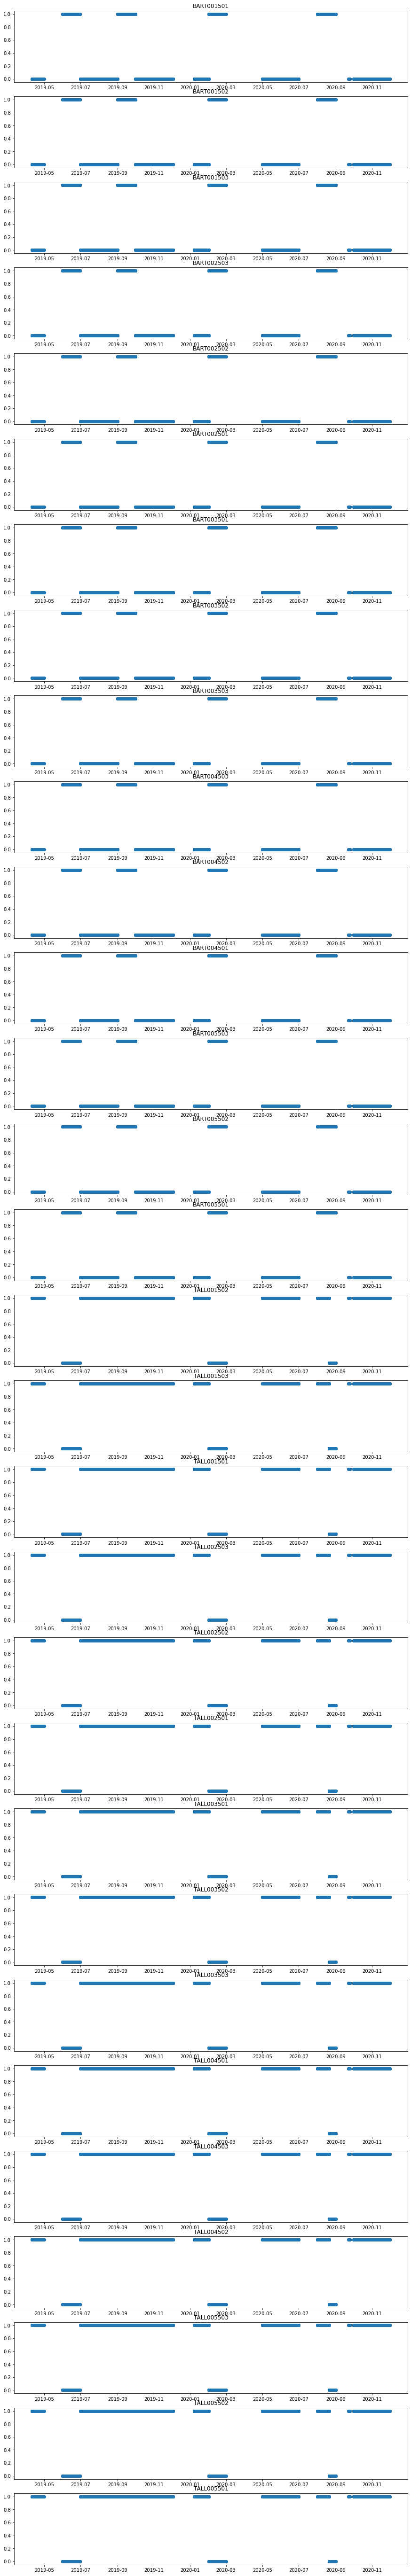

In [53]:

cols = list(hourly.columns)
fig, axs = plt.subplots(len(cols), figsize=(15, 100))
for i, col in enumerate(cols):
    axs[i].scatter(hourly.index, hourly[col]);
    axs[i].title.set_text(col)

In [ ]:
def make_pooled_hourly_data_parquet():
    

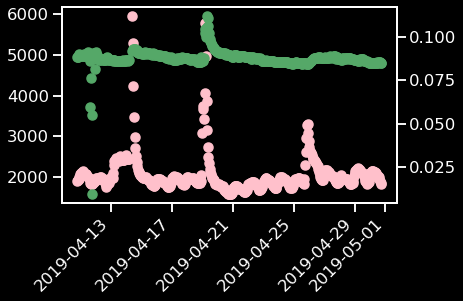

In [70]:
df = make_df('005', '501', '2019-04', 'TALL', data_path)

plt.style.use('dark_background')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='pink')
ax2.scatter(df.index, df.VSWCMean, c='g')
fig.autofmt_xdate(rotation=45)

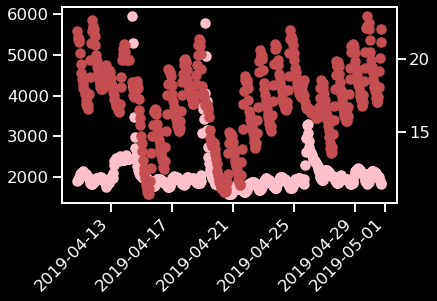

In [71]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='pink')
ax2.scatter(df.index, df.soilTempMean, c='r')
fig.autofmt_xdate(rotation=45)

Text(0.5, 0, 'CO2 (ppm?)')

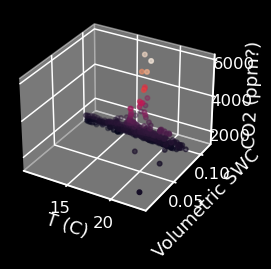

In [72]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = df.soilTempMean
y = df.VSWCMean
z = df.soilCO2concentrationMean

ax.scatter(x, y, z, c=z)

ax.set_xlabel('T (C)')
ax.set_ylabel('Volumetric SWC')
ax.set_zlabel('CO2 (ppm?)')

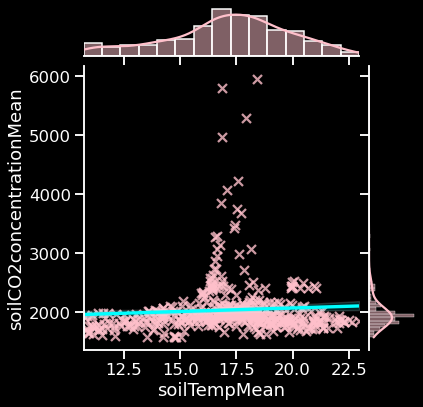

In [73]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='soilTempMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})
# aack I wosh seabor would give us r and p!


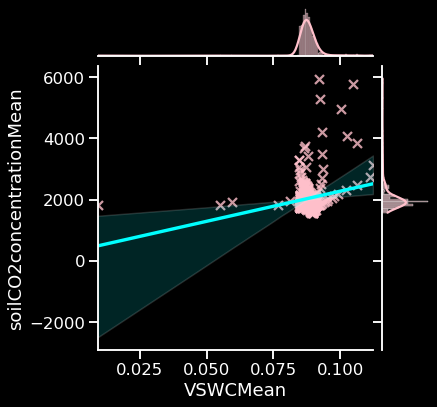

In [74]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


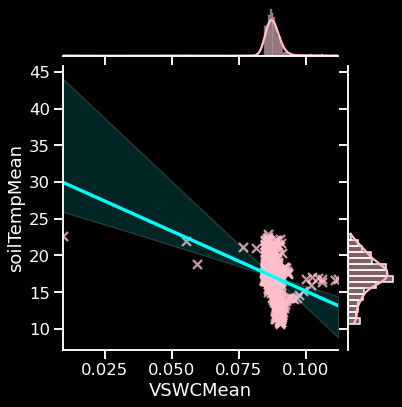

In [75]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilTempMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


### 1) ###
Judging from all of these plots I think there might be a T sensor malfunction insome of the data. Also, double check the sensor positions to make sure the T ansd H2O sensors are lined up. Extract the actual z offset for each from the senor positions to report with each analysis.  Probably ultimately w will want to save a pdf for each sensor with graPHS AND STATISTICAL INFO.

### 2) ###

__a)__ For each dataset in the training sets split to train and validations sets.

__b)__ Create a model. validate.

__c)__ Validate on holdout sites.


In [79]:
!pip install pyarrow

     |████████████████████████████████| 17.8 MB 4.8 MB/s eta 0:00:01    |█▌                              | 819 kB 4.8 MB/s eta 0:00:04     |██████████████████▎             | 10.1 MB 4.8 MB/s eta 0:00:02


In [80]:
def make_pooled_hourly_data_parquet():
    

,soilCO2concentrationMean,soilCO2concentrationMinimum,soilCO2concentrationMaximum,soilCO2concentrationVariance,soilCO2concentrationNumPts,soilCO2concentrationExpUncert,soilCO2concentrationStdErMean,VSWCMean,VSWCMinimum,VSWCMaximum,...,VSICNumPts,VSICExpUncert,VSICStdErMean,soilTempMean,soilTempMinimum,soilTempMaximum,soilTempVariance,soilTempNumPts,soilTempExpUncert,soilTempStdErMean
startDateTime,,,,,,,,,,,,,,,,,,,,,
2019-04-10 19:00:00+00:00,1887.311538,1881.911154,1892.519231,17.858077,6.0,26.718077,1.599727,0.088769,0.088538,0.089023,...,6.0,0.117115,0.058654,21.909462,21.904192,21.914808,0.000018,6.0,0.145942,0.001689
2019-04-10 20:00:00+00:00,1916.907931,1911.342414,1921.962069,16.594621,6.0,27.111724,1.593390,0.088566,0.088366,0.088759,...,6.0,0.008103,0.004069,21.503655,21.501103,21.506276,0.000005,6.0,0.145710,0.000828
2019-04-10 21:00:00+00:00,1921.062162,1915.340000,1926.505946,19.518703,6.0,27.211081,1.718816,0.088684,0.088481,0.088881,...,6.0,0.146486,0.073270,21.364135,21.362027,21.366162,0.000003,6.0,0.145670,0.000636
2019-04-10 22:00:00+00:00,1941.214737,1935.621316,1947.290263,20.281947,6.0,27.508421,1.782966,0.089903,0.088866,0.091376,...,6.0,0.042184,0.021132,21.384211,21.381947,21.386289,0.000003,6.0,0.145700,0.000653
2019-04-10 23:00:00+00:00,1997.735000,1993.060625,2003.103125,16.309687,6.0,28.235625,1.578638,0.090125,0.089450,0.090725,...,6.0,0.021875,0.011000,21.186125,21.181938,21.190062,0.000010,6.0,0.145606,0.001225
